In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable

In [2]:
def handle_action(level, x, y, action):
    # 0:Left    ---    1:Jump    ---    2:Right
    if action == 1:
        energy = 0
        # Air underneath Hubert - Fall downwards up to two cells.
        if level[y+1, x] == 1:
            y += 1
            if level[y + 1, x] == 1:
                y += 1
            return x, y, 0
        # Ground underneath Hubert, perform jump.
        else:
            check_jetpack = np.random.random()
            energy = -3 if check_jetpack else -5
            if level[y-1, x] != 2:
                y -= 1
                if level[y-1, x] != 2:
                    y -= 1
                    if check_jetpack < 0.33 and level[y-1, x] != 2:
                        y -= 1
    if action == 0:
        energy = -1
        # If possible, move left. Handle falling.
        if level[y, x-1] != 2:
            x -= 1
        if level[y+1, x] == 1:
            y += 1
            # Ground below us?
            if level[y+1, x] == 1:
                if level[y, x-1] != 2:
                    x -= 1
                if level[y+1, x] == 1:
                    y += 1
    if action == 2:
        energy = -1
        # If possible, move left. Handle falling.
        if level[y, x+1] != 2:
            x += 1
        if level[y+1, x] == 1:
            y += 1
            
            # Ground below us?
            if level[y+1, x] == 1:
                if level[y, x+1] != 2:
                    x += 1
                if level[y+1, x] == 1:
                    y += 1
    return x, y, energy


def handle_finished(x, y):
    return y == 1


def acc_window(x, y, level, enemies=[], size=4):
    window = np.zeros(((size * 2 + 1), (size * 2 + 1)))
    for idxi, i in enumerate(range(y - size, y + size + 1)):
        for idxj, j in enumerate(range(x - size, x + size + 1)):
            if i >= 0 and i <= 31 and j >= 0 and j <= 31:
                window[idxi,idxj] = level[i, j]

                # Show enemy as 3
                for my, mx, _ in enemies:
                    if i == my and j == mx:
                        window[idxi, idxj] = 3
                
            else:
                window[idxi,idxj] = 2
    return window


def select_action(x, y, level, hubert, enemies=[], epsilon=0.2):
    window = acc_window(x, y, level, enemies)
    window = window.flatten()
    window = torch.from_numpy(window)
    window = window.to(dtype=torch.float)
    action_vals = hubert(window)
    
    
    if np.random.random() < epsilon:
        choice = np.random.randint(3)
        return choice, action_vals[choice]
    action = torch.argmax(action_vals)
    action_val = torch.max(action_vals)
    return action.item(), action_val

def handle_caught(x, y, enemies):
    for my, mx in enemies:
        if y == my and x == mx:
            return True
    return False

In [14]:
def create_custom_map(p_air):
    altmap = np.ones((32, 32))
    altmap += 1
    enemies = []
    for i in range(1, altmap.shape[0] - 1):
        for j in range(1, altmap.shape[1] - 1):
            p_solid = (1 - p_air) * (2/5)
            p_semi = (1 - (p_air + p_solid))
            altmap[i, j] = np.random.choice([1, 2, 3], p=[p_air, (1-p_air) * (2/5), (1-p_air) * (3/5)])
            if altmap[i, j] == 2 and np.random.random() < 0.1:
                enemies.append((i-1, j))
                altmap[i-1, j] = 4
    return altmap, enemies

In [16]:
print(es)
np.save("HellishDelightEnemies", es)

[(5, 6), (5, 27), (5, 28), (7, 24), (10, 15), (13, 9), (17, 3), (17, 20), (20, 17), (23, 10), (29, 29)]


In [4]:
class Hubert(nn.Module):
    def __init__(self, window_size=4):
        super().__init__()
        self.fc1 = nn.Linear((window_size * 2 + 1) ** 2, 36)
        self.fc2 = nn.Linear(36, 3)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        y_hat = self.softmax(self.fc2(x))
        return y_hat

In [21]:
def episode(level, enemies, hubert, optim):
    # Constants
    MAX_ITERATIONS = 100000
    gamma = 1
    
    # Dynamics
    e0 = 500
    its = 0
    totrew = 0
    x = 1
    xs = np.array([x])
    y = 30
    ys = np.array([y])
    top_y = 30
    action, action_val = select_action(x, y, level, hubert)
    while(True):
        reward = 0
        next_x, next_y, energy = handle_action(level, x, y, action)
        
        if handle_caught(next_x, next_y, enemies):
            #print("Caught by MM, breaking.")
            reward = 0
            optim.zero_grad()
            loss = -(reward*torch.log(action_val) + (1-reward) * torch.log(1 - action_val))
            loss = Variable(loss.data, requires_grad=True)
            loss.backward()
            optim.step()
            break
        
        if handle_finished(x, y):
            #print("Reached y = 1, breaking.")
            reward = 1
            optim.zero_grad()
            loss = -(reward*torch.log(action_val) + (1-reward) * torch.log(1 - action_val))
            loss = Variable(loss.data, requires_grad=True)
            loss.backward()
            optim.step()
            break
            
        if next_y < top_y:
            top_y = next_y
            e0 += 100
            reward = 1
        if next_y < y:
            reward = 1
            
        if not (next_x == x or next_y == y):
            reward = 1
            
            
            
        
        next_action, next_action_val = select_action(x, y, level, hubert)
        optim.zero_grad()
        loss = -(reward*torch.log(next_action_val) + (1-reward) * torch.log(1 - next_action_val))
        loss.backward()
        optim.step()
        
        x = next_x
        y = next_y
        xs = np.append(xs, x)
        ys = np.append(ys, y)
        e0 += energy
        action = next_action
        action_val = next_action_val.detach()
        its += 1
        
        if e0 <= 0:
            #print("Energy depleted, breaking.")
            break
        if its > MAX_ITERATIONS:
            #print("Exceeded step limit, breaking.")
            break
    
    return xs, ys, top_y, its
        
    

  0%|          | 0/100000 [00:00<?, ?it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))


0.8834191018108569


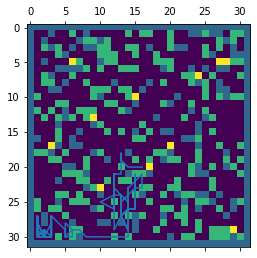

  0%|          | 1/100000 [00:00<11:31:00,  2.41it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  0%|          | 200/100000 [01:15<8:22:41,  3.31it/s] 

0.8834191018108569


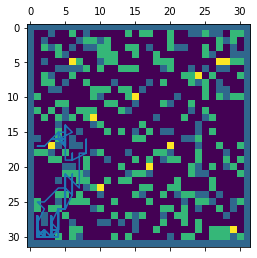

  0%|          | 201/100000 [01:15<9:48:04,  2.83it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  0%|          | 400/100000 [02:42<12:44:55,  2.17it/s]

0.8834191018108569


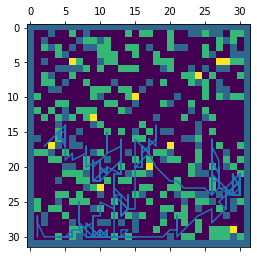

  0%|          | 401/100000 [02:42<15:20:56,  1.80it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  1%|          | 600/100000 [04:00<13:38:22,  2.02it/s]

0.8834191018108569


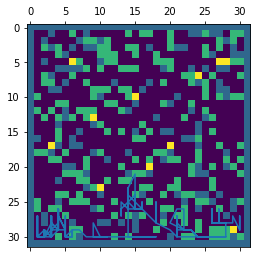

  1%|          | 601/100000 [04:00<13:26:09,  2.06it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  1%|          | 800/100000 [05:07<10:28:35,  2.63it/s]

0.8834191018108569


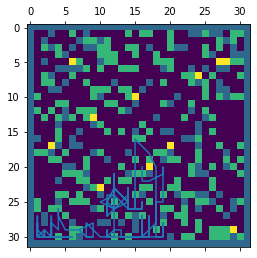

  1%|          | 801/100000 [05:08<10:53:36,  2.53it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  1%|          | 1000/100000 [06:17<9:52:28,  2.78it/s]

0.8834191018108569


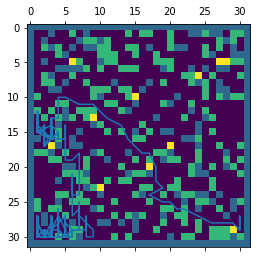

  1%|          | 1001/100000 [06:17<12:07:25,  2.27it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  1%|          | 1200/100000 [07:30<13:31:44,  2.03it/s]

0.8834191018108569


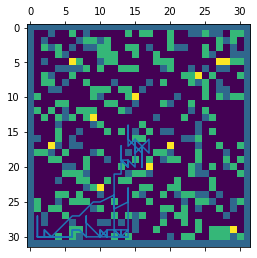

  1%|          | 1201/100000 [07:30<12:46:48,  2.15it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  1%|▏         | 1400/100000 [08:41<8:54:52,  3.07it/s] 

0.8834191018108569


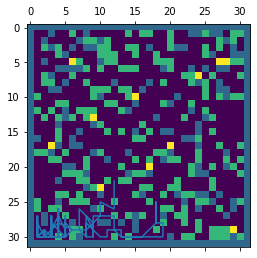

  1%|▏         | 1401/100000 [08:41<9:09:40,  2.99it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  2%|▏         | 1600/100000 [09:53<10:04:15,  2.71it/s]

0.8834191018108569


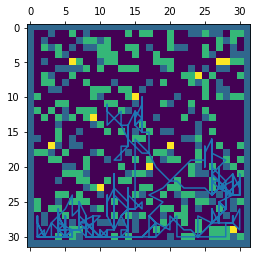

  2%|▏         | 1601/100000 [09:54<15:28:24,  1.77it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  2%|▏         | 1800/100000 [11:01<9:54:49,  2.75it/s] 

0.8834191018108569


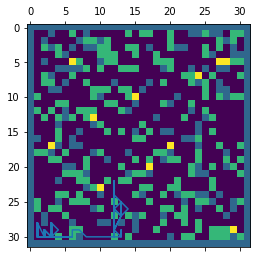

  2%|▏         | 1801/100000 [11:02<9:01:51,  3.02it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  2%|▏         | 1999/100000 [12:09<6:34:56,  4.14it/s] 

0.8834191018108569


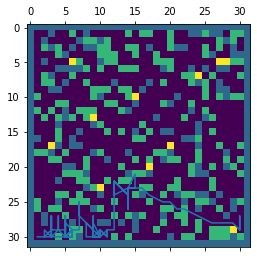

  2%|▏         | 2001/100000 [12:10<6:19:46,  4.30it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  2%|▏         | 2200/100000 [13:21<11:11:46,  2.43it/s]

0.8834191018108569


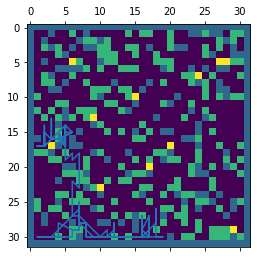

  2%|▏         | 2201/100000 [13:21<11:15:08,  2.41it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  2%|▏         | 2400/100000 [14:32<9:29:02,  2.86it/s] 

0.8834191018108569


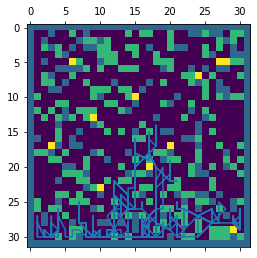

  2%|▏         | 2401/100000 [14:33<13:57:10,  1.94it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  3%|▎         | 2600/100000 [15:42<10:51:13,  2.49it/s]

0.8834191018108569


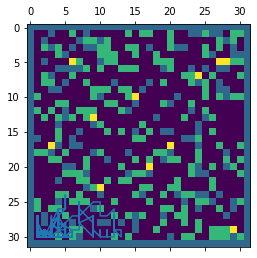

  3%|▎         | 2601/100000 [15:43<12:53:48,  2.10it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  3%|▎         | 2800/100000 [16:50<9:13:15,  2.93it/s] 

0.8834191018108569


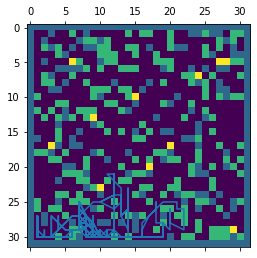

  3%|▎         | 2801/100000 [16:51<12:09:36,  2.22it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  3%|▎         | 3000/100000 [18:08<16:55:07,  1.59it/s]

0.8834191018108569


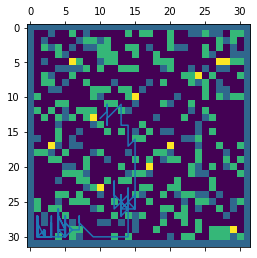

  3%|▎         | 3001/100000 [18:08<16:09:43,  1.67it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  3%|▎         | 3200/100000 [19:39<11:17:16,  2.38it/s]

0.8834191018108569


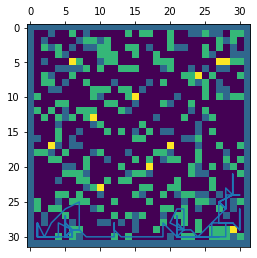

  3%|▎         | 3201/100000 [19:40<12:11:31,  2.21it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  3%|▎         | 3400/100000 [21:11<13:17:39,  2.02it/s]

0.8834191018108569


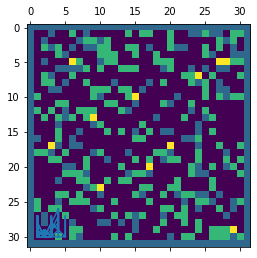

  3%|▎         | 3401/100000 [21:12<13:59:54,  1.92it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  4%|▎         | 3600/100000 [22:27<6:45:09,  3.97it/s] 

0.8834191018108569


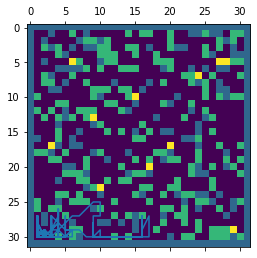

  4%|▎         | 3601/100000 [22:28<9:09:52,  2.92it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  4%|▍         | 3800/100000 [23:52<6:12:23,  4.31it/s] 

0.8834191018108569


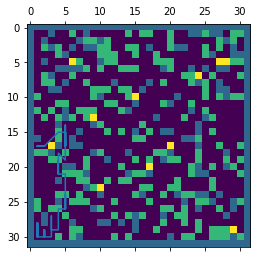

  4%|▍         | 3801/100000 [23:52<6:17:07,  4.25it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  4%|▍         | 4000/100000 [25:23<10:29:51,  2.54it/s]

0.8834191018108569


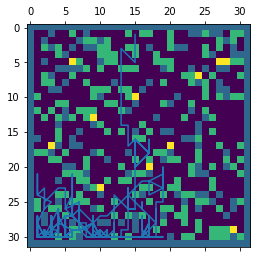

  4%|▍         | 4001/100000 [25:24<14:31:44,  1.84it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  4%|▍         | 4200/100000 [26:55<12:04:49,  2.20it/s]

0.8834191018108569


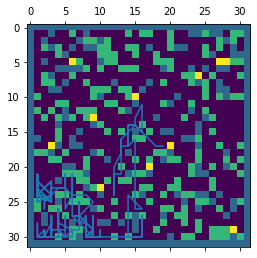

  4%|▍         | 4201/100000 [26:56<15:14:17,  1.75it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  4%|▍         | 4400/100000 [28:28<13:44:48,  1.93it/s]

0.8834191018108569


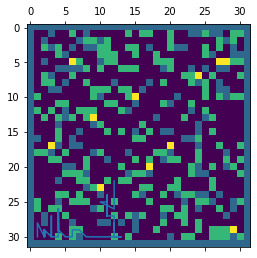

  4%|▍         | 4401/100000 [28:28<12:53:56,  2.06it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  5%|▍         | 4600/100000 [29:53<11:58:37,  2.21it/s]

0.8834191018108569


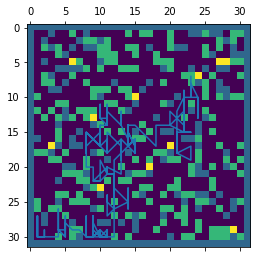

  5%|▍         | 4601/100000 [29:53<13:12:43,  2.01it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  5%|▍         | 4800/100000 [31:03<10:00:12,  2.64it/s]

0.8834191018108569


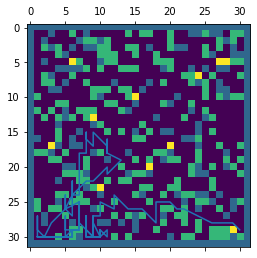

  5%|▍         | 4801/100000 [31:04<10:38:51,  2.48it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  5%|▌         | 5000/100000 [32:21<8:27:19,  3.12it/s] 

0.8834191018108569


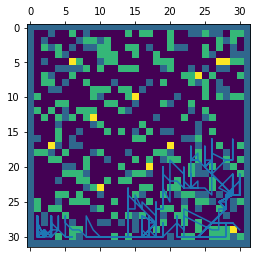

  5%|▌         | 5001/100000 [32:22<12:16:01,  2.15it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  5%|▌         | 5200/100000 [33:51<17:09:28,  1.53it/s]

0.8834191018108569


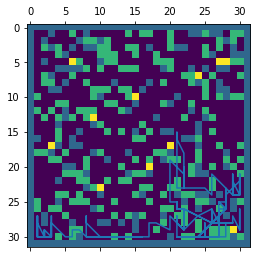

  5%|▌         | 5201/100000 [33:51<16:58:31,  1.55it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  5%|▌         | 5400/100000 [35:05<11:49:34,  2.22it/s]

0.8834191018108569


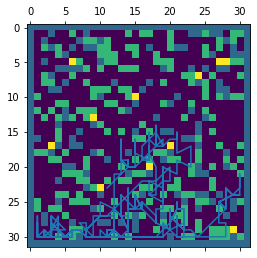

  5%|▌         | 5401/100000 [35:06<13:57:59,  1.88it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  6%|▌         | 5600/100000 [36:25<8:29:19,  3.09it/s] 

0.8834191018108569


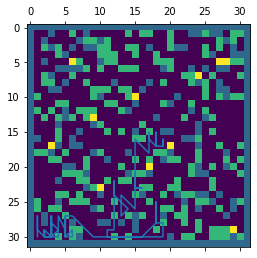

  6%|▌         | 5601/100000 [36:26<8:42:49,  3.01it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  6%|▌         | 5800/100000 [37:47<10:38:21,  2.46it/s]

0.8834191018108569


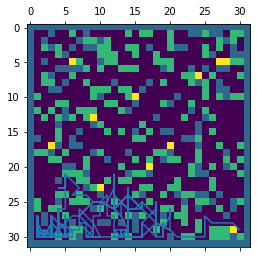

  6%|▌         | 5801/100000 [37:48<14:10:13,  1.85it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  6%|▌         | 6000/100000 [39:16<8:34:35,  3.04it/s] 

0.8834191018108569


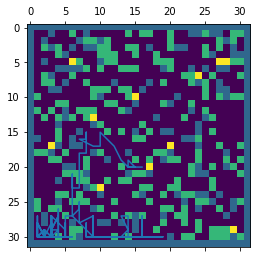

  6%|▌         | 6001/100000 [39:17<9:17:33,  2.81it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  6%|▌         | 6200/100000 [40:42<13:23:39,  1.95it/s]

0.8834191018108569


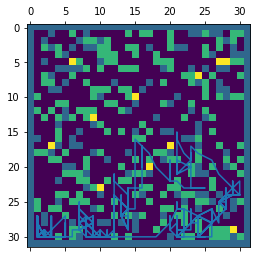

  6%|▌         | 6201/100000 [40:43<20:53:44,  1.25it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  6%|▋         | 6400/100000 [42:03<7:05:15,  3.67it/s] 

0.8834191018108569


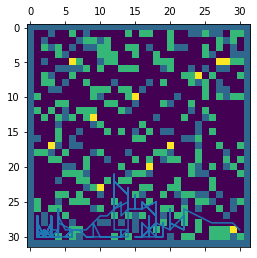

  6%|▋         | 6401/100000 [42:04<10:05:37,  2.58it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  7%|▋         | 6600/100000 [43:22<5:04:59,  5.10it/s] 

0.8834191018108569


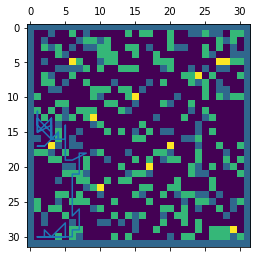

  7%|▋         | 6601/100000 [43:22<6:01:28,  4.31it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  7%|▋         | 6800/100000 [44:47<11:20:10,  2.28it/s]

0.8834191018108569


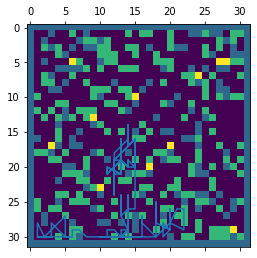

  7%|▋         | 6801/100000 [44:47<11:29:23,  2.25it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  7%|▋         | 7000/100000 [46:00<10:54:49,  2.37it/s]

0.8834191018108569


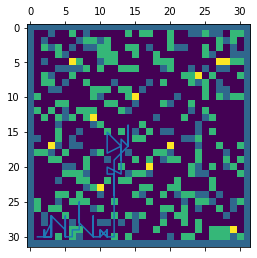

  7%|▋         | 7001/100000 [46:01<10:09:50,  2.54it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  7%|▋         | 7200/100000 [47:24<10:53:29,  2.37it/s]

0.8834191018108569


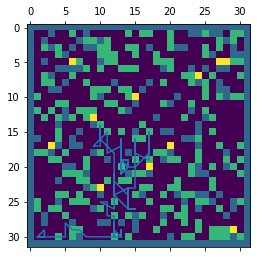

  7%|▋         | 7201/100000 [47:24<10:21:47,  2.49it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  7%|▋         | 7400/100000 [48:48<8:26:51,  3.04it/s] 

0.8834191018108569


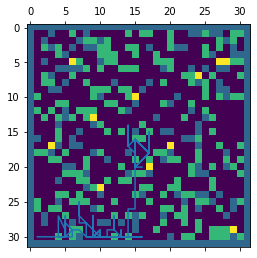

  7%|▋         | 7401/100000 [48:48<8:26:39,  3.05it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  8%|▊         | 7600/100000 [50:10<8:33:10,  3.00it/s] 

0.8834191018108569


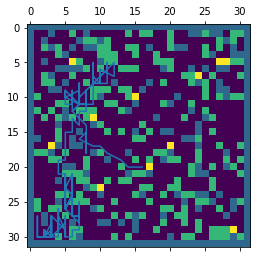

  8%|▊         | 7601/100000 [50:11<9:53:52,  2.59it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  8%|▊         | 7800/100000 [51:37<7:12:13,  3.56it/s] 

0.8834191018108569


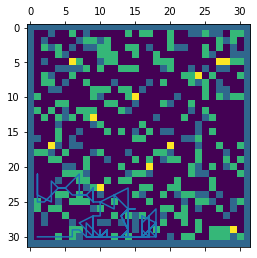

  8%|▊         | 7801/100000 [51:38<8:10:49,  3.13it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  8%|▊         | 8000/100000 [53:01<13:57:10,  1.83it/s]

0.8834191018108569


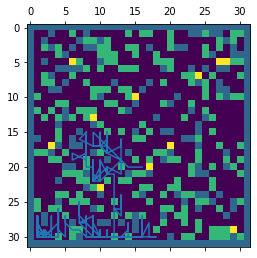

  8%|▊         | 8001/100000 [53:02<15:35:43,  1.64it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  8%|▊         | 8200/100000 [54:26<7:54:53,  3.22it/s] 

0.8834191018108569


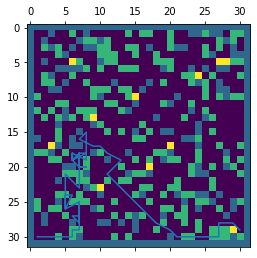

  8%|▊         | 8201/100000 [54:27<8:02:01,  3.17it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  8%|▊         | 8400/100000 [55:47<10:45:42,  2.36it/s]

0.8834191018108569


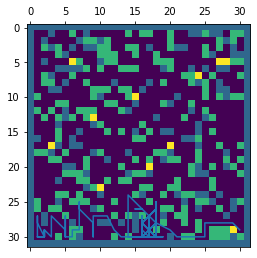

  8%|▊         | 8401/100000 [55:48<10:59:50,  2.31it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  9%|▊         | 8600/100000 [57:18<9:49:57,  2.58it/s] 

0.8834191018108569


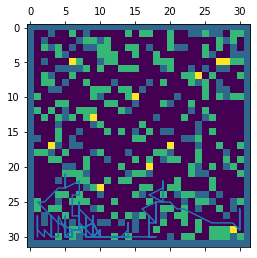

  9%|▊         | 8601/100000 [57:19<9:47:32,  2.59it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  9%|▉         | 8800/100000 [58:39<8:41:35,  2.91it/s] 

0.8834191018108569


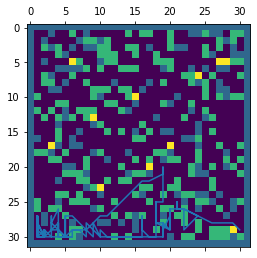

  9%|▉         | 8801/100000 [58:40<9:39:45,  2.62it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  9%|▉         | 9000/100000 [59:54<9:26:12,  2.68it/s] 

0.8834191018108569


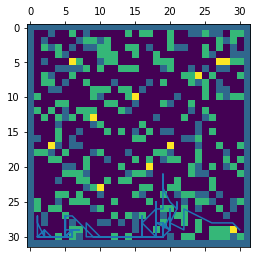

  9%|▉         | 9001/100000 [59:55<9:26:17,  2.68it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  9%|▉         | 9200/100000 [1:01:18<9:12:17,  2.74it/s] 

0.8834191018108569


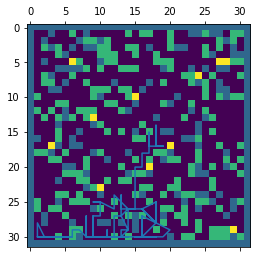

  9%|▉         | 9201/100000 [1:01:18<9:08:02,  2.76it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
  9%|▉         | 9400/100000 [1:02:29<7:58:37,  3.15it/s] 

0.8834191018108569


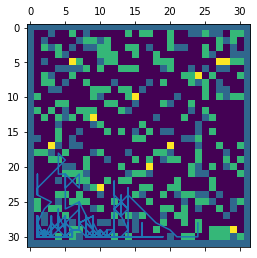

  9%|▉         | 9401/100000 [1:02:30<10:54:30,  2.31it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 10%|▉         | 9600/100000 [1:03:38<11:44:53,  2.14it/s]

0.8834191018108569


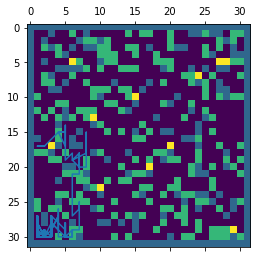

 10%|▉         | 9601/100000 [1:03:38<11:47:48,  2.13it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 10%|▉         | 9800/100000 [1:04:50<9:31:04,  2.63it/s] 

0.8834191018108569


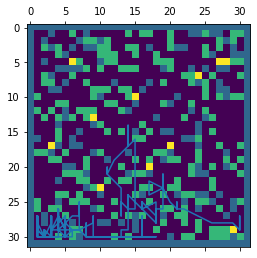

 10%|▉         | 9801/100000 [1:04:51<11:13:08,  2.23it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 10%|█         | 10000/100000 [1:06:08<8:08:35,  3.07it/s]

0.8834191018108569


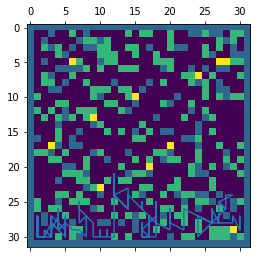

 10%|█         | 10001/100000 [1:06:08<9:00:45,  2.77it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 10%|█         | 10200/100000 [1:07:37<6:18:14,  3.96it/s] 

0.8834191018108569


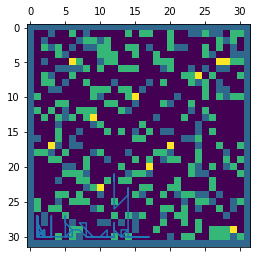

 10%|█         | 10201/100000 [1:07:37<6:48:16,  3.67it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 10%|█         | 10400/100000 [1:08:54<9:22:14,  2.66it/s] 

0.8834191018108569


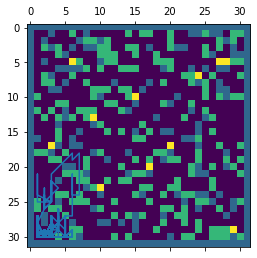

 10%|█         | 10401/100000 [1:08:55<12:19:59,  2.02it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 11%|█         | 10600/100000 [1:10:05<10:38:54,  2.33it/s]

0.8834191018108569


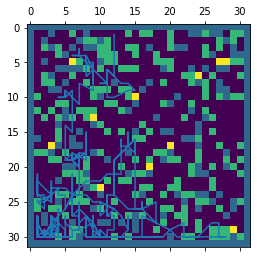

 11%|█         | 10601/100000 [1:10:07<16:14:10,  1.53it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 11%|█         | 10800/100000 [1:11:23<8:32:21,  2.90it/s] 

0.8834191018108569


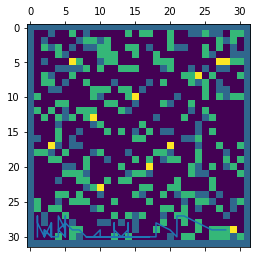

 11%|█         | 10801/100000 [1:11:23<7:58:33,  3.11it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 11%|█         | 11000/100000 [1:12:43<10:37:15,  2.33it/s]

0.8834191018108569


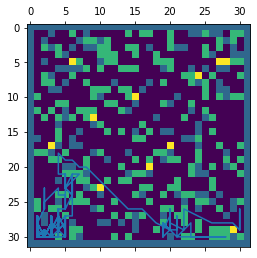

 11%|█         | 11001/100000 [1:12:44<13:14:17,  1.87it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 11%|█         | 11200/100000 [1:14:01<8:05:04,  3.05it/s] 

0.8834191018108569


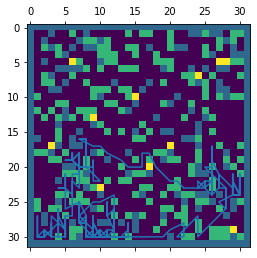

 11%|█         | 11201/100000 [1:14:01<10:53:42,  2.26it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 11%|█▏        | 11400/100000 [1:15:16<10:44:21,  2.29it/s]

0.8834191018108569


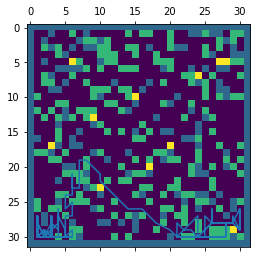

 11%|█▏        | 11401/100000 [1:15:16<11:25:46,  2.15it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 12%|█▏        | 11600/100000 [1:16:47<12:31:57,  1.96it/s]

0.8834191018108569


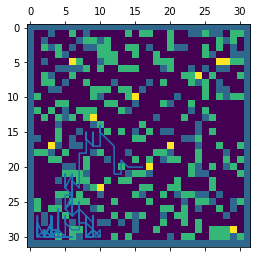

 12%|█▏        | 11601/100000 [1:16:48<13:16:14,  1.85it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 12%|█▏        | 11800/100000 [1:18:05<9:19:56,  2.63it/s] 

0.8834191018108569


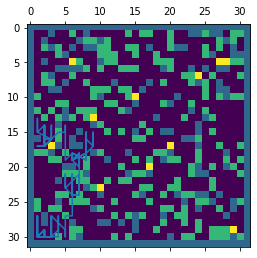

 12%|█▏        | 11801/100000 [1:18:06<9:42:57,  2.52it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 12%|█▏        | 11999/100000 [1:19:29<8:37:34,  2.83it/s] 

0.8834191018108569


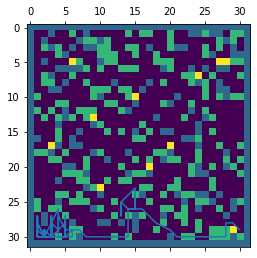

 12%|█▏        | 12001/100000 [1:19:29<6:54:34,  3.54it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 12%|█▏        | 12200/100000 [1:20:39<11:17:52,  2.16it/s]

0.8834191018108569


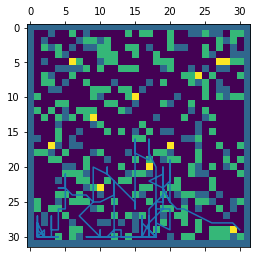

 12%|█▏        | 12201/100000 [1:20:40<10:58:30,  2.22it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 12%|█▏        | 12400/100000 [1:22:01<8:32:42,  2.85it/s] 

0.8834191018108569


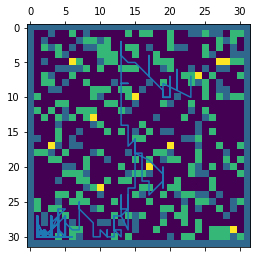

 12%|█▏        | 12401/100000 [1:22:01<10:39:51,  2.28it/s]<ipython-input-4-58bff37c10eb>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(self.fc2(x))
 12%|█▏        | 12467/100000 [1:22:32<9:27:54,  2.57it/s] 

In [ ]:
hubert = Hubert()
hubert.load_state_dict(torch.load("ex6Hubert"))
optim = torch.optim.Adam(hubert.parameters(), lr=0.1)


p_air = min(0.9, np.random.beta(6, 2))
p_air = max(0.6, p_air)
level, enemies = create_custom_map(p_air)
for e in tqdm(range(100000)):
    # Draw p_air from beta dist, bind to [0.6, 0.9]
    #p_air = min(0.9, np.random.beta(6, 2))
    #p_air = max(0.6, p_air)
    #level, enemies = create_custom_map(p_air)
    level = np.load("HellishDelight.npy")
    enemies = np.load("HellishDelightEnemies.npy")
    xs, ys, top_y, its = episode(level, enemies, hubert, optim)
    torch.save(hubert.state_dict(), "ex6Hubert")
    if e % 200 == 0:
        print(p_air)
        plt.matshow(level)
        plt.plot(xs, ys)
        plt.show()
    